In [47]:
import psycopg2
import numpy as np
import datetime
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as pplot
import os

In [34]:
conncommend = "host='localhost' port=2345 dbname='expdata' user='postgres' password='psql123'"
conn = psycopg2.connect(conncommend)

In [101]:
root = 'D:\\expdata\\DL134\\190227_DL134'
BVDIAM = 'D:\\expdata\\2P\\BVDIAM'
WHEEL = 'D:\\expdata\\2P\\WHEEL'

In [49]:
os.path.basename(root)

'190227_DL134'

In [99]:
def list2array(list):
    tmp = str(list).replace('(', '{').replace(')', '}').replace('[', '{').replace(']', '}').replace('\'', '\"')
    return(tmp)

def absoArray(array):
    tmp = array[1:] - array[0:-1]
    return(tmp)

def wheeldata(root, runs):
    data = []
    basename = os.path.basename(root)
    for run in runs:
        runname = basename+'_run'+str(run)
        runpath = os.path.join(root, runname)
        runfile = [x for x in os.listdir(runpath) if '_quadrature.mat' in x]
        runfile = runfile[0]
        tmp = sio.loadmat(os.path.join(root, runname, runfile))
        data = np.append(data, absoArray(tmp['quad_data'][0]))
    return(data)

def bvdata(root, runs, bvid):
    data = []
    basename = os.path.basename(root)
    for run in runs:
        runname = basename+'_run'+str(run)
        runpath = os.path.join(root, runname, 'bv_'+str(bvid), 'result.mat')
        tmp = sio.loadmat(runpath)
        data = np.append(data, tmp['diameter_value'])
    return(data)
        
def expfileid(animal, date, bvid):
    ids = {}
    ids['bv_file_id'] = 'bvd' + animalid+date.strftime('%y%m%d') + 'a' + str(bvid) + 'a'
    ids['wheel_file_id'] = 'wheel' + animalid+date.strftime('%y%m%d') + 'a'
    return(ids)
    
        
    

In [16]:
researcher = list2array(['Jun Zhao'])
note = ''
date = datetime.datetime.strptime('2-27-2019', '%m-%d-%Y')
projectid = list2array([2])
animalid = 'DL134'

In [105]:
runs = [1,2]
bvid = 1
ids = expfileid(animalid, date, bvid)

<h1> Update wheel data and return wheel data id

In [108]:
data = wheeldata(root, runs)
data = np.reshape(data, [1, -1])
shape = list2array(np.shape(data))

np.save(os.path.join(WHEEL, ids['wheel_file_id']+'.npy'), data)

cur = conn.cursor()
cur.execute(
    """
    INSERT INTO data_2p
    values ('{}', 15, '{}', '{}', 'WHEEL')
    """.format(ids['wheel_file_id'], shape, 'WHEEL\\'+ids['wheel_file_id']+'.npy')
)
conn.commit()


<h1> Update blood vessel diameter data and return blood vessel id

In [110]:
bvid = 1
hz = 3
ids = expfileid(animalid, date, bvid)

data = bvdata(root, runs, bvid)
data = np.reshape(data, [1, -1])

np.save(os.path.join(BVDIAM, ids['bv_file_id']+'.npy'), data)

cur = conn.cursor()
cur.execute(
    """
    INSERT INTO data_2p
    values ('{}', {}, '{}', '{}', 'BVDIAM')
    """.format(ids['bv_file_id'], hz, shape, 'BVDIAM\\'+ids['wheel_file_id']+'.npy')
)
conn.commit()

<h1> Update exp info

In [113]:
datalog = []

# blood vessel diameter
datalog = np.append(datalog, {'record_type': 'blood vessel diameter', 
                              'bv_type': 'artery',
                              'depth': 20,
                              'bvid': bvid, 
                              'dataid': ids['bv_file_id'], 
                              'treatment': {'1': 2830}
                             })
                    
# wheel running                  
datalog = np.append(datalog, {'record_type': 'wheel running',
                              'dataid': ids['wheel_file_id'],
                              'treatment': {'0': 0, '1': 27900}
                             })

# treatment
datalog = np.append(datalog, {'record_type': 'treatment',
                              '0': {'method': 'baseline'}, 
                              '1': {'method':'CSD', 'csd_method': 'pinprick'}
                             })

In [100]:
expfileid(animalid, date, 1)

{'bv_file_id': 'bvdDL134190227a1a', 'wheel_file_id': 'wheelDL134190227a'}

In [15]:
projectid

'{2}'

In [23]:
data = []
files = ['D:\\expdata\\DL134\\190227_DL134\\190227_DL134_run1\\bv_1\\result.mat', 
         'D:\\expdata\\DL134\\190227_DL134\\190227_DL134_run2\\bv_1\\result.mat']

for file in files:
    tmp = sio.loadmat(file)
    data = np.append(data, tmp['diameter_value'])

In [21]:
data1 = sio.loadmat('D:\\expdata\\DL134\\190227_DL134\\190227_DL134_run1\\bv_1\\result.mat')

In [22]:
data1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb 28 10:31:58 2019',
 '__version__': '1.0',
 '__globals__': [],
 'response_fig': array([[1715.56666667, 1539.83333333, 1527.63333333, ..., 1539.23333333,
         1797.06666667, 2399.63333333],
        [1792.31666667, 1795.39444444, 1550.29444444, ..., 1900.42777778,
         1946.79444444, 1983.17222222],
        [1758.85405405, 2049.03243243, 1764.51351351, ..., 2016.38918919,
         2044.02162162, 2181.32432432],
        ...,
        [1921.19393939, 2337.90909091, 2373.55151515, ..., 3919.66666667,
         2457.47878788, 2785.71515152],
        [2097.74857143, 2533.93142857, 2527.22857143, ..., 2626.49714286,
         2717.28571429, 2850.39428571],
        [2178.21538462, 2521.18461538, 2954.64615385, ..., 3002.46153846,
         2914.95384615, 2929.8       ]]),
 'diameter_value': array([[45, 44, 43, ..., 72, 71, 72]], dtype=int16)}

In [25]:
np.shape(data)

(11160,)

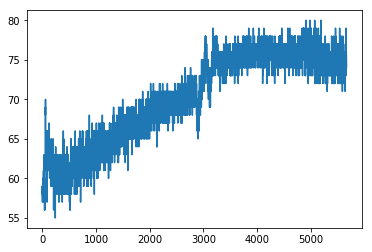

In [28]:
pplot.plot(data[2709:2790+5580])

In [ ]:
datalog = {}
datalog['BVDIAM'] = {'dataid': expid, treatment = {'1': 0, '2': 2830}}
datalog['WHEEL'] = 
datalog['treatment'] = {'0': {'method':'baseline'}, '1': {'method':'CSD', 'csd_method': 'pinprick'}}

<h1> update data_2p

In [41]:
expid = 'bvd'+animalid+date.strftime('%y%m%d')+'a1a'
shape = list2array(np.shape(np.reshape(data[2709:2790+5580], [1, -1])))
# np.save(BVDIAM+'\\'+expid, np.reshape(data[2709:2790+5580], [1, -1]))

In [44]:
cur = conn.cursor()
cur.execute(
    """
    INSERT INTO data_2p
    values ('{}', 3, '{}', '{}', 'BVDIAM')
    """.format(expid, shape, 'BVDIAM\\'+expid+'.npy')
)
conn.commit()

In [144]:
cur = conn.cursor()
cur.execute('rollback;')
conn.commit()

dsfsdfsfsdfsf

In [120]:
tmp = 'D:\\Jun\\lab_data\\project\\neuron_character.csv'
base = np.loadtxt(tmp, delimiter = ',', dtype = str) #[str, str, float, float, str, bool, bool, int, int, int, int, str, float, float, float]))

In [123]:
base[1]

array(['N2013040101', 'C', '26', '', 'slowAdp', 'Y', '', '0', '1', '', '',
       'A2013040101', '0.004444433', '', ''], dtype='<U32')

In [136]:
def fillnull(value):
    if value == '':
        return('null')
    else:
        return(value)
    
def yorn(value):
    if value == 'Y':
        return('true')
    elif value == 'N':
        return('false')
    elif value == '':
        return('null')

In [129]:
base1 = fillnull(base)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [145]:
for i in range(1, len(base)):
    cur = conn.cursor()
    cur.execute(
        """
        INSERT INTO data_ep_singleneuron
        values ('{}', {}, {}, '{}', {}, {}, {}, {}, {}, {}, '{}', {}, {}, {},'{}')
        """.format(base[i][0], fillnull(base[i][2]), fillnull(base[i][3]), fillnull(base[i][4]), yorn(base[i][5]), 
                   yorn(base[i][6]), fillnull(base[i][7]), fillnull(base[i][8]), fillnull(base[i][9]), fillnull(base[i][10]),
                   fillnull(base[i][11]), fillnull(base[i][12]), fillnull(base[i][13]), fillnull(base[i][14]), fillnull(base[i][1])
                  )
    )
    conn.commit()